In [1]:
import os
import sys
import pandas as pd
import numpy as np
import time
import tables
import warnings
from datetime import date, datetime, timedelta
from pvoutput import *

In [2]:
BASE_PATH = os.path.expanduser('~/data/pvoutput.org/')
INPUT_PV_LIST_FILENAME = os.path.join(BASE_PATH, 'UK_PV_listing_metadata.hdf')
METADATA_FILENAME = os.path.join(BASE_PATH, 'UK_PV_metadata.csv')
OUTPUT_TIMESERIES_FILENAME = os.path.join(BASE_PATH, 'UK_PV_timeseries.hdf')
PV_STATS_FILENAME = os.path.join(BASE_PATH, 'UK_PV_stats.csv')
MISSING_DATA_FILENAME = os.path.join(BASE_PATH, 'UK_PV_missing_timeseries_data.csv')
START_DATE = pd.Timestamp("2019-01-01")
END_DATE = pd.Timestamp("2019-07-01")

logger = get_logger(stream_handler=False)

In [3]:
pv_systems = pd.read_hdf(INPUT_PV_LIST_FILENAME, 'metadata')

In [4]:
pv_systems.head()

,Array Tilt,Inverter,Location,Orientation,Panels,Shade,system_capacity,system_name,Outputs,Generation,Average,Efficiency,system_capacity_kw,efficiency_kWh_per_kW,system_1_tilt_degrees,system_2_tilt_degrees
system_id,,,,,,,,,,,,,,,,
26965,11.0°,Enphase M215,United Kingdom CV47,South 0.0°,336x250W Q Cells Pro-G3 250,Low,84.000kW,mfl_phc,1813 days,399.238MWh,220.208kWh,2.654kWh/kW,84.00,2.654,11.0,NaN
24768,NaN,aurora trio,United Kingdom OX7,South 180.0°,1050x240W qidong,No,252.000kW,mfl_qfa,446 days,307.029MWh,688.405kWh,2.732kWh/kW,252.00,2.732,NaN,NaN
11542,15.0°,SMA TRI-Power 1700 TL,United Kingdom PE11,South 180.0°,200x250W Emmvee ES 230 M60 B,No,50.000kW,Wray Farms Solar System,2437 days,293.684MWh,120.510kWh,2.477kWh/kW,50.00,2.477,15.0,NaN
66991,40.0°,Unknown,United Kingdom HR8,South 180.0° / South West 225.0°,152x325W + 80x325W Unknown,No,75.400kW,Ledbury Community Hospital,1434 days,279.902MWh,195.190kWh,2.603kWh/kW,75.40,2.603,40.0,NaN
5116,15.0°,Fronius CL36; Datamanager 2.0,United Kingdom OX7,South 180.0°,182x235W Q.Base-G2 235,No,42.770kW,mfl_scf,2538 days,267.470MWh,105.386kWh,2.493kWh/kW,42.77,2.493,15.0,NaN


In [5]:
pv_metadata = pd.read_csv(METADATA_FILENAME, index_col='system_id')

In [6]:
pv_metadata.head()

,system_name,system_size_watts,postcode,number_of_panels,panel_power_watts,panel_brand,num_inverters,inverter_power_watts,inverter_brand,orientation,array_tilt_degrees,shade,install_date,latitude,longitude,status_interval_minutes,number_of_panels_secondary,panel_power_watts_secondary,orientation_secondary,array_tilt_degrees_secondary
system_id,,,,,,,,,,,,,,,,,,,,
19397,AndyT's,3900,BS22,20,195,ZN Shine 195w,1,3500,Kaco 4202,S,30.0,No,2011-11-21 00:00:00,51.36,-2.92,5,0,0,NaN,NaN
8195,Kilmarnock Roof,3750,KA3,15,250,Sanyo 250 HIT,1,4000,Omniksol,S,30.0,No,2011-11-07 00:00:00,55.64,-4.49,10,0,0,NaN,NaN
8200,Flat 5,3430,E8,14,245,NaN,1,3000,sb3000,S,25.0,Low,2011-12-12 00:00:00,51.54,-0.06,5,0,0,NaN,NaN
8204,Sooper-Dooper Solar,2940,GU2,12,245,SunTech STP245S-20/Wd,1,3000,Kaco Powador 3002,S,19.0,No,2012-05-11 00:00:00,51.24,-0.59,10,0,0,NaN,NaN
8205,58GPR,4000,BS48,16,250,Sanyo component Europe GmbH,1,50,Sma sunny boysb3800v,S,NaN,No,2011-11-10 00:00:00,51.42,-2.74,10,0,0,NaN,NaN


In [7]:
pv_stats = pd.read_csv(
    PV_STATS_FILENAME, 
    index_col='system_id',
    parse_dates=['actual_date_from', 'actual_date_to', 'record_efficiency_date']
)
pv_stats.head()

,energy_generated_Wh,energy_exported_Wh,average_generation_Wh,minimum_generation_Wh,maximum_generation_Wh,average_efficiency_kWh_per_kW,outputs,actual_date_from,actual_date_to,record_efficiency_kWh_per_kW,record_efficiency_date,stats_downloaded_on_utc
system_id,,,,,,,,,,,,
12290,28040596.0,0.0,10068.0,0.0,28548.0,2.543,2785.0,2011-11-30,2019-07-21,570.96,2013-05-25 00:00:00,1.563877e+18
8200,6399918.0,77311.0,7950.0,2.0,31047.0,2.388,805.0,2012-05-01,2014-10-14,620.94,2012-09-08 00:00:00,1.563877e+18
4105,12214111.0,7482325.0,9239.0,0.0,44085.0,2.924,1322.0,2011-10-11,2015-05-24,881.70,2015-03-23 00:00:00,1.563877e+18
53258,0.0,0.0,0.0,0.0,0.0,0.000,584.0,2017-07-15,2019-02-20,0.00,2019-02-20 00:00:00,1.563877e+18
8205,4313500.0,0.0,10546.0,0.0,27500.0,210.920,409.0,2011-11-11,2012-12-23,550.00,2012-05-16 00:00:00,1.563877e+18


In [8]:
pv_systems_joined = (
    pv_systems
    .join(
        pv_metadata[['status_interval_minutes', 'install_date', 'latitude', 'longitude']],
        how='left'
    ).join(
        pv_stats[['actual_date_from', 'actual_date_to', 'outputs']],
        how='left'
    ))

In [9]:
# Filter 'bad' systems
pv_systems_filtered = pv_systems_joined.query(
    'status_interval_minutes <= 60 and'
    ' outputs > 100 and'
    ' actual_date_from <= @START_DATE and'
    ' actual_date_to >= @END_DATE')
pv_systems_filtered = pv_systems_filtered.dropna(subset=['latitude', 'longitude'])

In [10]:
len(pv_systems_filtered)

829

In [11]:
pv_systems_filtered.head()

,Array Tilt,Inverter,Location,Orientation,Panels,Shade,system_capacity,system_name,Outputs,Generation,...,efficiency_kWh_per_kW,system_1_tilt_degrees,system_2_tilt_degrees,status_interval_minutes,install_date,latitude,longitude,actual_date_from,actual_date_to,outputs
system_id,,,,,,,,,,,,,,,,,,,,,
26965,11.0°,Enphase M215,United Kingdom CV47,South 0.0°,336x250W Q Cells Pro-G3 250,Low,84.000kW,mfl_phc,1813 days,399.238MWh,...,2.654,11.0,NaN,5,2014-01-17 00:00:00,52.230000,-1.380000,2014-01-08,2019-07-23,1815.0
11542,15.0°,SMA TRI-Power 1700 TL,United Kingdom PE11,South 180.0°,200x250W Emmvee ES 230 M60 B,No,50.000kW,Wray Farms Solar System,2437 days,293.684MWh,...,2.477,15.0,NaN,5,2011-12-08 00:00:00,52.800000,-0.160000,2012-09-12,2019-07-23,2439.0
5116,15.0°,Fronius CL36; Datamanager 2.0,United Kingdom OX7,South 180.0°,182x235W Q.Base-G2 235,No,42.770kW,mfl_scf,2538 days,267.470MWh,...,2.493,15.0,NaN,10,2011-12-07 00:00:00,51.945568,-1.385417,2011-12-09,2019-07-23,2540.0
5701,1.0°,SMA Tripower 8000TL,United Kingdom DA1,South 180.0°,46x215W Schuco,Low,9.890kW,Workshop,2837 days,78.561MWh,...,2.868,1.0,NaN,5,NaN,51.420000,0.110000,2011-10-15,2019-07-23,2839.0
28016,30.0°,SMA Sunny Boy 17000TL,United Kingdom CB3,South 180.0° / South East 135.0°,80x240W + 44x240W REW 240 Premium QM60,No,29.760kW,Robinson College,772 days,77.214MWh,...,3.383,30.0,NaN,5,2013-10-10 00:00:00,52.210000,0.020000,2014-03-22,2019-07-23,774.0


In [32]:
data.index.duplicated().sum()

22176

In [ ]:
def get_dates_already_downloaded(system_id):
    if os.path.exists(OUTPUT_TIMESERIES_FILENAME):
        with pd.HDFStore(OUTPUT_TIMESERIES_FILENAME, mode='r') as store:
            key = str(system_id)
            try:
                datetimes = store.select(key=key, columns=['datetime'])
            except KeyError:
                already_processed = set([])
            else:
                already_processed = datetimes.sort_index().index.date
                already_processed = set(already_processed)
    else:
        already_processed = set([])
    return already_processed

In [18]:
def safe_convert_to_date(dt):
    if isinstance(dt, pd.Timestamp):
        return dt.date()
    if isinstance(dt, date):
        return dt
    
# test
DATE_TEST = date(2019, 1, 1)
assert DATE_TEST == safe_convert_to_date(DATE_TEST)
assert DATE_TEST == safe_convert_to_date(pd.Timestamp(DATE_TEST))

In [ ]:
logger.info('\n******* STARTING UP ************')


# Get list of missing dates
with pd.HDFStore(OUTPUT_TIMESERIES_FILENAME, mode='r') as store:
    try:
        all_missing_dates = store['missing_dates']
    except KeyError:
        all_missing_dates = pd.DataFrame()

print('Number of missing dates found so far:', len(all_missing_dates))


system_id = 0  # Just so logger.exception has something to process if necessary.
try:
    n = len(pv_systems_filtered)
    api_request_i = 0
    for i, system_id in enumerate(pv_systems_filtered.index):
        msg = 'system_id {:d}: {:d} of {:d} ({:.0%}) '.format(system_id, i, n, i/n)
        print('\r', msg, end='', flush=True)
        logger.info('****************************')
        logger.info(msg)
        date_range = pd.date_range(START_DATE, END_DATE, freq="D", normalize=True).date
        
        # Don't download dates that we already have on disk
        dates_already_downloaded = get_dates_already_downloaded(system_id)
        date_range = set(date_range) - set(dates_already_downloaded)
        logger.info('system_id %d: %d days already downloaded.', system_id, len(dates_already_downloaded))

        # Check for dates that we've already requested, but are missing:
        try:
            missing_dates_for_id = all_missing_dates.loc[system_id]
        except KeyError:
            # We don't know of any missing dates for this system_id
            pass
        else:
            missing_dates_for_id = missing_dates_for_id['date']
            if isinstance(missing_dates_for_id, pd.Timestamp):
                missing_dates_for_id = [missing_dates_for_id]
            else:
                missing_dates_for_id = missing_dates_for_id.to_list()

            missing_dates_for_id = [safe_convert_to_date(dt) for dt in missing_dates_for_id]
            logger.info('system_id %d: %d missing dates already found: %s', system_id, len(missing_dates_for_id),
                        ', '.join([dt.strftime('%Y-%m-%d') for dt in missing_dates_for_id]))
            date_range = set(date_range) - set(missing_dates_for_id)

        date_range = np.sort(list(date_range))
        if len(date_range) > 0:
            logger.info("system_id %d: Will download %d days: from %s to %s",
                        system_id, len(date_range), date_range[0], date_range[-1])
        else:
            logger.info("system_id %d: No data left to download :)", system_id)
        for date_to_load in date_range:
            api_request_i += 1
            logger.info("system_id %d: Requesting system status for %s (API request number %d)",
                        system_id, date_to_load, api_request_i)
            date_to_load_str = date_to_pvoutput_str(date_to_load)
            try:
                timeseries = get_pv_system_status(system_id, date_to_load_str)
            except NoStatusFound as e:
                logger.info("system_id %d: No status found for %s.", system_id, date_to_load)
                missing_dates = pd.DataFrame({'date': pd.Timestamp(date_to_load)},
                                             index=[system_id])
                with pd.HDFStore(OUTPUT_TIMESERIES_FILENAME, mode='a', complevel=9) as store:
                    store.append(key='missing_dates', value=missing_dates)
            else:
                logger.info("system_id %d: %d rows retrieved", system_id, len(timeseries))
                check_pv_system_status(timeseries, date_to_load_str)
                with pd.HDFStore(OUTPUT_TIMESERIES_FILENAME, mode='a', complevel=9) as store:
                    with warnings.catch_warnings():
                        warnings.simplefilter('ignore', tables.NaturalNameWarning) 
                        store.append(key=str(system_id), value=timeseries)
except:
    logger.exception('system_id %d: Exception!', system_id)

Number of missing dates found so far: 12387
 system_id 28278: 293 of 829 (35%) 

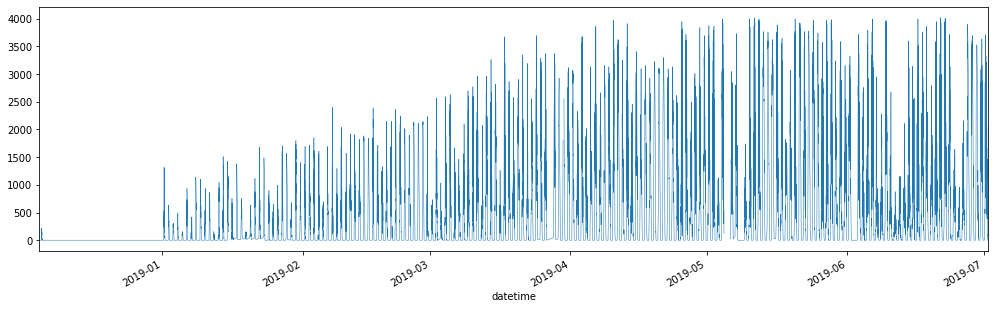

In [46]:
def get_data_from_hdf(system_id):
    with pd.HDFStore(OUTPUT_TIMESERIES_FILENAME, mode='r') as store:
        data = store.select(key=str(system_id))
    return data

system_id = 2998
timeseries = get_data_from_hdf(system_id)

timeseries['inst_power_watt'].plot(figsize=(17, 5), linewidth=0.5);

In [47]:
timeseries['inst_power_watt'].isnull().sum()

55

In [48]:
pv_systems_filtered.loc[system_id]

Array Tilt                                    30.0°
Inverter                                 SMA 4000TL
Location                         United Kingdom NG9
Orientation                              East 90.0°
Panels                     20x190W Schuco 190 MS 05
Shade                                            No
system_capacity                             3.800kW
system_name                            The Bowler's
Outputs                          2894 days 00:00:00
Generation                                32.299MWh
Average                                   11.161kWh
Efficiency                              3.086kWh/kW
system_capacity_kw                              3.8
efficiency_kWh_per_kW                         3.086
system_1_tilt_degrees                            30
system_2_tilt_degrees                           NaN
status_interval_minutes                          10
install_date                    2011-08-12 00:00:00
latitude                                    52.9485
longitude   

In [49]:
timeseries.index.duplicated().sum()

0

In [45]:
# Sort indicies and set all types to float64
# And remove duplicate indicies
with pd.HDFStore(OUTPUT_TIMESERIES_FILENAME, mode='r') as store:
    keys = store.keys()
    
for key in keys:
    print('\r', key, end='', flush=True)
    if key == '/missing_dates':
        continue
    data = get_data_from_hdf(key)
    data = data.sort_index()
    data = data.loc[~data.index.duplicated()]
    for col in data.columns:
        data[col] = data[col].astype(np.float64)
    
    with pd.HDFStore(OUTPUT_TIMESERIES_FILENAME, mode='a', complevel=9) as store:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', tables.NaturalNameWarning) 
            store.put(key, data, format='table', append=False)

 /missing_dates